In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import mediapipe as mp
import cv2
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import os
from tensorflow.keras.models import load_model

In [7]:
# Expressions labels
expressions = ["anger", "disgust", "fear", "happy", "sad", "surprise", "neutral"]
train_data_dir = '/content/Dataset/train/'
test_data_dir = '/content/Dataset/test/'

In [8]:
# Moving window for smoothing predictions
PREDICTION_WINDOW = deque(maxlen=5)

In [9]:
# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False, max_num_faces=5, min_detection_confidence=0.5
)

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, VGG19


def build_model(type):
    """Build the CNN model."""
    #  Load VGG19 with pretrained ImageNet weights
    if type == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    else:
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))


    # Freeze the base layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    output = Dense(7, activation='softmax')(x)  # Example: 10 classes

    # Create new model
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model
# build_model()

In [11]:
def train_model(tp,model, train_dir, test_dir, epochs=50):
    """Train the model with given data."""
    # Data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=30,
        shear_range=0.3,
        zoom_range=0.3,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode="rgb",
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        shuffle = True
    )
    validation_generator = test_datagen.flow_from_directory(
        test_data_dir,
        color_mode="rgb",
        target_size=(48,48),
        batch_size=32,
        class_mode="categorical",
        shuffle = True
    )

    num_train_imgs = 0
    for root, dirs, files in os.walk(train_data_dir):
        num_train_imgs += len(files)
    num_test_imgs = 0
    for root, dirs, files in os.walk(test_data_dir):
        num_test_imgs += len(files)

    print(num_train_imgs)
    print(num_test_imgs)

    history = model.fit(
        train_generator,
        steps_per_epoch=num_train_imgs // 32,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_test_imgs // 32,

    )

    model.save(f"model_{tp}.h5")

    return history

In [12]:
def preprocess_face(face_img):
    """Preprocess a face image for prediction."""
    gray = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    normalized = resized / 255.0
    return normalized.reshape(1, 48, 48, 1)

In [13]:
def detect_expression(frame, model):
    """Detect facial expression in a video frame."""
    height, width, _ = frame.shape
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            x_min = y_min = float("inf")
            x_max = y_max = float("-inf")

            for landmark in face_landmarks.landmark:
                x, y = int(landmark.x * width), int(landmark.y * height)
                x_min = min(x_min, x)
                x_max = max(x_max, x)
                y_min = min(y_min, y)
                y_max = max(y_max, y)

            padding = 20
            x_min = max(0, x_min - padding)
            y_min = max(0, y_min - padding)
            x_max = min(width, x_max + padding)
            y_max = min(height, y_max + padding)

            face = frame[y_min:y_max, x_min:x_max]
            if face.size == 0:
                continue

            processed_face = preprocess_face(face)
            prediction = model.predict(processed_face)[0]
            PREDICTION_WINDOW.append(prediction)

            avg_prediction = np.mean(PREDICTION_WINDOW, axis=0)
            expression = expressions[np.argmax(avg_prediction)]
            confidence = float(avg_prediction.max())

            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(
                frame,
                f"{expression} ({confidence:.2f})",
                (x_min, y_min - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9,
                (0, 255, 0),
                2,
            )

    return frame

In [14]:
def run_realtime(model):
    """Run real-time facial expression detection."""
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        processed_frame = detect_expression(frame, model)

        cv2.imshow("Facial Expression Detection", processed_frame)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    cap.release()
    cv2.destroyAllWindows()

In [15]:
def evaluate_model(model, test_dir, history):
    """Evaluate the model and visualize the results."""
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        color_mode="rgb",
        shuffle=False,
    )

    # Get predictions and calculate metrics
    predictions = model.predict(test_generator)
    true_labels = test_generator.classes
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    report = classification_report(
        true_labels, predicted_labels, target_names=expressions
    )
    accuracy = np.sum(true_labels == predicted_labels) / len(true_labels)

    print(f"Overall Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(report)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=expressions,
        yticklabels=expressions,
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Plot Accuracy and Loss over Epochs
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [16]:
def main():

    types = ['vgg19','vgg16']
    for tp in types:
      print(f"Model type: {tp}")
      # Build the model
      model = build_model(tp)

      # Train the model (optional, you can load a pretrained model)
      # train = input("Do you want to train the model? (y/n): ")
      # if train.lower() == 'y':
      #     history = train_model(tp,model, train_data_dir, test_data_dir, epochs=2)
      # else:
      #     # Load pre-trained model (if available)
      #     if os.path.exists(f"model_{tp}.h5"):
      #         model = load_model("model_CNN.h5")
      #         print("Model loaded successfully.")
      #     else:
      #         print("No pre-trained model found. You should train the model first.")
      #         return
      history = train_model(tp,model, train_data_dir, test_data_dir, epochs=68)

      # Evaluate the model on the test set
      # evaluate = input("Do you want to evaluate the model? (y/n): ")
      # if evaluate.lower() == 'y':
      evaluate_model(model, test_data_dir, history)

      # Run real-time facial expression detection
      # run_realtime_choice = input("Do you want to run real-time facial expression detection? (y/n): ")
      # if run_realtime_choice.lower() == 'y':
      #     run_realtime(model)

Model type: vgg19
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
28709
7178
Epoch 1/68


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 51s 52ms/step - accuracy: 0.2739 - loss: 1.7793 - val_accuracy: 0.3107 - val_loss: 1.7090
Epoch 2/68
  1/897 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - accuracy: 0.2188 - loss: 1.6997

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2188 - loss: 1.6997 - val_accuracy: 0.3100 - val_loss: 1.7058
Epoch 3/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 71s 48ms/step - accuracy: 0.3022 - loss: 1.7124 - val_accuracy: 0.3237 - val_loss: 1.6705
Epoch 4/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2500 - loss: 1.6998 - val_accuracy: 0.3238 - val_loss: 1.6682
Epoch 5/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - accuracy: 0.3244 - loss: 1.6876 - val_accuracy: 0.3405 - val_loss: 1.6380
Epoch 6/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3438 - loss: 1.6147 - val_accuracy: 0.3391 - val_loss: 1.6381
Epoch 7/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.3238 - loss: 1.6840 - val_accuracy: 0.3299 - val_loss: 1.6751
Epoch 8/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3438 - loss: 1.6495 - val_accuracy: 0.3323 - val_loss: 1.6693
Epoch 9/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 142s 96ms/step - accuracy: 0.3266 - loss: 1.6762 - val_accuracy: 0.35

Found 7178 images belonging to 7 classes.
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step
Overall Accuracy: 37.60%

Classification Report:
              precision    recall  f1-score   support

       anger       0.30      0.23      0.26       958
     disgust       0.00      0.00      0.00       111
        fear       0.33      0.11      0.16      1024
       happy       0.40      0.67      0.50      1774
         sad       0.32      0.41      0.36      1233
    surprise       0.39      0.16      0.23      1247
     neutral       0.47      0.56      0.51       831

    accuracy                           0.38      7178
   macro avg       0.32      0.31      0.29      7178
weighted avg       0.36      0.38      0.34      7178



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


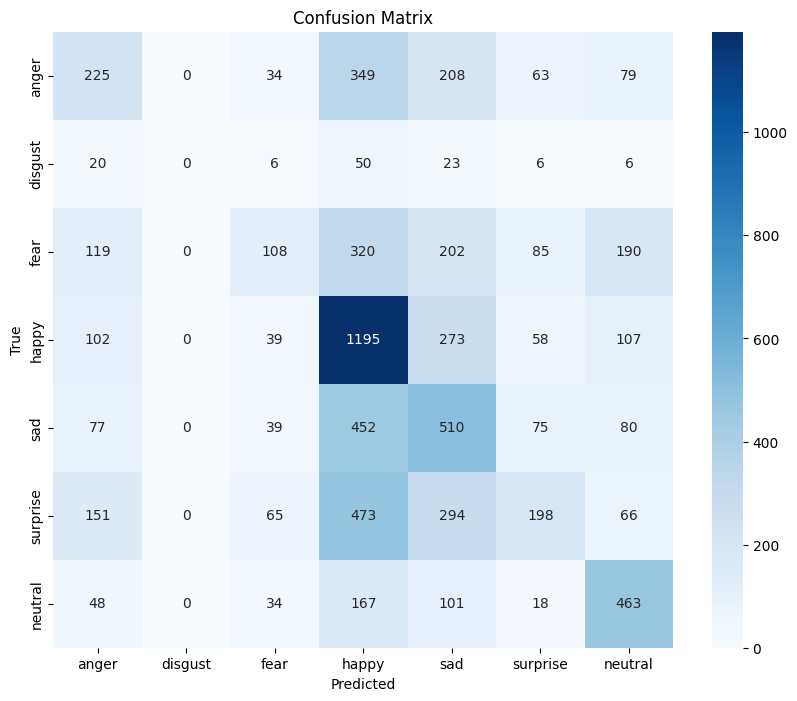

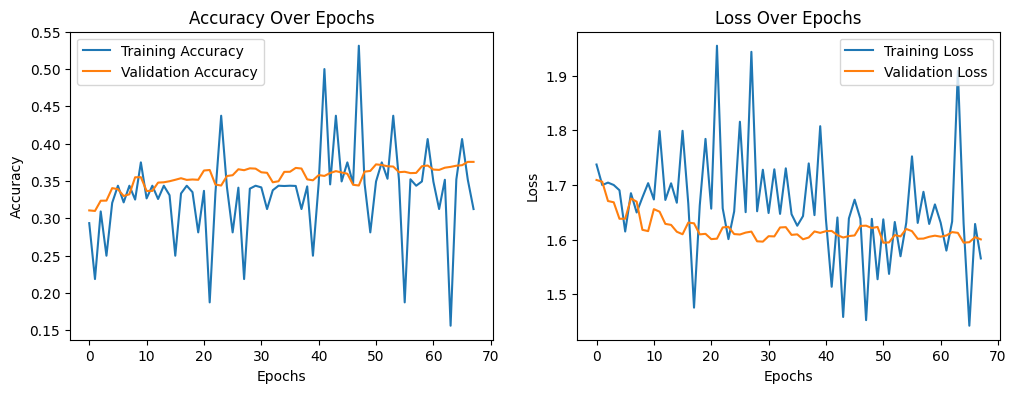

Model type: vgg16
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
28709
7178
Epoch 1/68


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 48s 52ms/step - accuracy: 0.2907 - loss: 1.7561 - val_accuracy: 0.3478 - val_loss: 1.6390
Epoch 2/68
  1/897 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.2188 - loss: 1.7698

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2188 - loss: 1.7698 - val_accuracy: 0.3458 - val_loss: 1.6409
Epoch 3/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.3291 - loss: 1.6759 - val_accuracy: 0.3415 - val_loss: 1.6566
Epoch 4/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4688 - loss: 1.5925 - val_accuracy: 0.3384 - val_loss: 1.6673
Epoch 5/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 79s 49ms/step - accuracy: 0.3257 - loss: 1.6708 - val_accuracy: 0.3690 - val_loss: 1.6098
Epoch 6/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5000 - loss: 1.6526 - val_accuracy: 0.3657 - val_loss: 1.6116
Epoch 7/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - accuracy: 0.3357 - loss: 1.6591 - val_accuracy: 0.3705 - val_loss: 1.6035
Epoch 8/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2500 - loss: 1.6802 - val_accuracy: 0.3686 - val_loss: 1.6064
Epoch 9/68
897/897 ━━━━━━━━━━━━━━━━━━━━ 76s 49ms/step - accuracy: 0.3439 - loss: 1.6440 - val_accuracy: 0.373

In [ ]:
if __name__ == "__main__":
    main()